<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Random Forests</div>

1. [Random Forests](#sec1)
2. [Examples](#sec2)
    1. [Spam or ham?](#sec2-1)
    2. [NIST](#sec2-2)

# <a id="sec1"></a> 1. Random Forests

Key idea: Grow a forest of trees by introducing randomness.

Randomness in:
-  Training subset selection (Bagging)
- Feature selection in each node

**Reminder: growing trees**

**FormTree($T$)**<br>
<ol>
<li> Find best split $(j, s)$ over $T$ // Which criterion?
<li> If $(j, s) = \emptyset$, 
    <ul>
    <li>  node = FormLeaf(T) // Which value for the leaf?
    </ul>
<li> Else
    <ul>
    <li> node = $(j, s)$
    <li> split $T$ according to $(j, s)$ into $(T1, T2)$
    <li> append FormTree($T1$) to node // Recursive call
    <li> append FormTree($T2$) to node
    </ul>
<li> Return node
</ol>

**New: random feature selection**

During step 1 (splitting) of FormTree(T), only search for the best split among a random subset of features.

Size of the subset has little importance. Usual choices:
- $\sqrt{p}$ in common cases
- 1 for fully randomized feature selection (still gives accurate results!)

**Reminder: Forest growth by Bagging of trees**

Example Set $T$, samples $x^1,\ldots, x^N$.<br>
For $b=1$ to $B$
1. Sample (with replacement) bootstrap replicate $T^b$ from $T$
2. $\varphi^b(x) \leftarrow$ FormTree($T^b$)

Return $\varphi_B(x) = \arg\max\limits_{y} \sum\limits_{b=1}^B I(\varphi^b(x) = y)$

<div class="alert alert-success">
    
**Random Forests**
<ul>
<li> Fully grown trees
<li> + Random feature selection
<li> + Bagging
</ul>
</div>

**Margin guarantees?**

Margin of a random forest in $(x,y)$ = 
probability of classifying correctly $x$, minus probability of the most probable wrong class.<br>
$$m(x,y) = \mathbb{P}_\Theta\left(h\left(x,\Theta\right)=y\right) - \max\limits_{j\neq y}\mathbb{P}_\Theta\left(h\left(x,\Theta\right)=j\right)$$
As more trees are added, Random Forests converge to a bound in generalization error and do not overfit the training set.


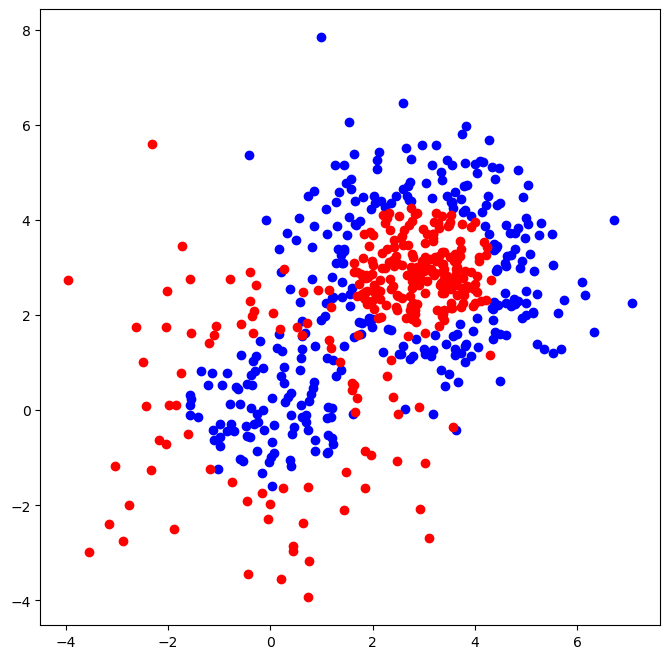

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

def gen_data(seed):
    X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=seed)
    X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=seed)
    X = np.concatenate((X1, X2))
    y = np.concatenate((y1, - y2 + 1))
    y = 2*y-1
    X, y = shuffle(X, y)
    return X, y

X,y = gen_data(1)
Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(8,8))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r');

Generalization error: 0.105


<Figure size 800x800 with 0 Axes>

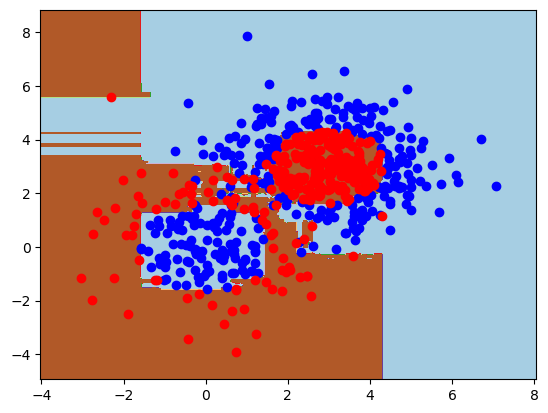

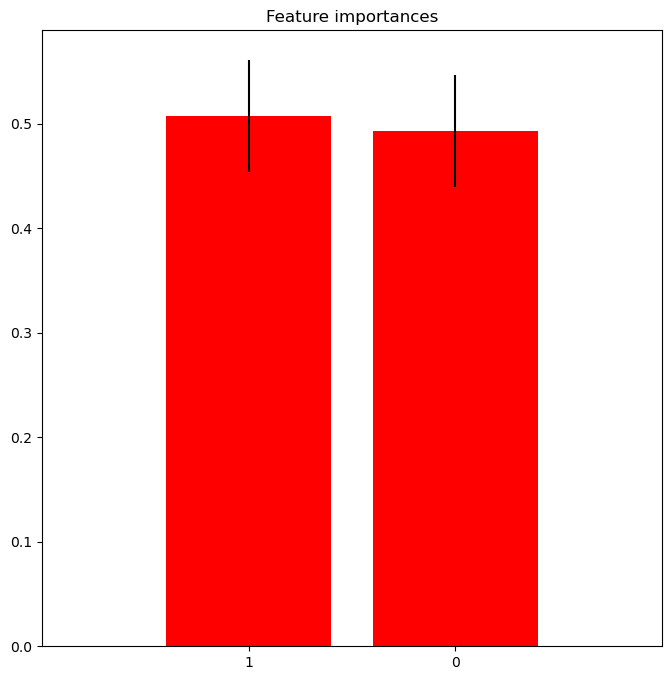

In [2]:
from sklearn.ensemble import RandomForestClassifier

### Generate data
X,y = gen_data(1)
Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

def plot_decision_boundary(f,X,y):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = f.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure()
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = f.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b')
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v')
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r')
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v')
    plt.show()

rf = RandomForestClassifier(n_estimators=101, criterion='entropy')
rf.fit(X,y)

# Plot
print("Generalization error: %g"%(1.-rf.score(Xtest,ytest)))
plt.figure(figsize=(8,8))
plot_decision_boundary(rf,X,y)

# Feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Random Forests provide an interesting **feature importance** estimation mechanism. Let's illustrate it.

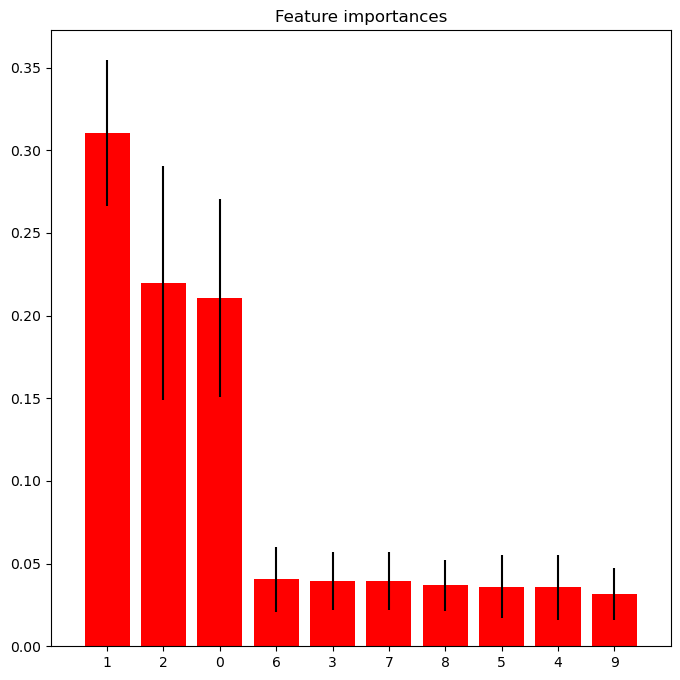

In [3]:
# A more demonstrative example
# Build a classification task using 10 features but only 3 informative ones.
X, y = datasets.make_classification(n_samples=1000,
                                    n_features=10,
                                    n_informative=3,
                                    n_redundant=0,
                                    n_repeated=0,
                                    n_classes=2,
                                    random_state=0,
                                    shuffle=False)
rf = RandomForestClassifier(n_estimators=51, criterion='entropy')
rf.fit(X,y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# <a id="sec4"></a> 4. Examples

## <a id="sec4-1"></a> 4.1 Spam or ham?

In [4]:
from sys import path
path.append('../2 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()
print("data loaded")

Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

/Users/astel/mambaforge/envs/py-latest/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


data loaded


In [8]:
Xtrain.shape

(2000, 14282)

<div class="alert alert-warning">
    
**Exercice:** train a Random Forest on this tf-idf data and evaluate its generalization performance.
</div>

In [10]:
# %load solutions/code1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
spam_RF.fit(Xtrain,ytrain)

spam_RF.score(Xtest.toarray(),ytest)

# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000)
    spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
    spam_RF.fit(Xtrain,ytrain);
    score += [spam_RF.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))


******************** done!
Average generalization score: 0.9730683090705486
Standard deviation: 0.0079379026884453


<div class="alert alert-warning">
    
**Exercice:** Evaluate how the same Random Forest trained on raw word counts performs.
</div>

In [11]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')

In [13]:
# %load solutions/code2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
spam_RF.fit(Xtrain,ytrain)
spam_RF.score(Xtest,ytest)

# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000, feat='wordcount')
    spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
    spam_RF.fit(Xtrain,ytrain);
    score += [spam_RF.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))


******************** done!
Average generalization score: 0.9835946248600222
Standard deviation: 0.0056799869061191725


Let's keep this last classifier and identify which are the misclassified emails.

In [14]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat="wordcount")
spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
spam_RF.fit(Xtrain,ytrain);

In [15]:
# Find misclassified examples
ypredict = spam_RF.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

Misclassified messages indices: [5, 28, 32, 57, 74, 97, 270, 293, 294, 309, 423, 486, 583, 796, 798, 853]


In [16]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

Confusion matrix:
[[739   0]
 [ 16 138]]


In [17]:
# Check some misclassified mails
index = misclass_indices[0]+2000
print("Prediction:", spam_RF.predict(spam_data.word_count[index,:]))
spam_data.print_email(index)
spam_RF.predict_proba(spam_data.word_count[index,:])

Prediction: [False]
email file: ../data/lingspam_public/bare/part7/spmsgb95.txt
email is a spam: True
Subject: what is you lifeplan ?

lifeplan - goal setting shareware lifeplan helps you to decide exactly what you want to achieve with your life . it then helps you to set the targets and goals that will guide you to this achievement . download lifeplan now to take control of what could be a great life ! you can get lifeplan from http : / / www . btinternet . com / ~ mindtools / index . htm l lifeplan is shareware , so you can try it before you buy it .

Bag of words representation (19 words in dictionary):
{'subject': np.int64(1), 'index': np.int64(1), 'could': np.int64(1), 'try': np.int64(1), 'buy': np.int64(1), 'set': np.int64(1), 'take': np.int64(1), 'want': np.int64(1), 'control': np.int64(1), 'get': np.int64(1), 'life': np.int64(2), 'great': np.int64(1), 'exactly': np.int64(1), 'setting': np.int64(1), 'decide': np.int64(1), 'achieve': np.int64(1), 'goal': np.int64(1), 'guide': np.

array([[0.56, 0.44]])

Remember there are 14279 features. Let's plot the histogram of feature importances for the 100 most important ones (and their standard deviation).

Let's also print the 20 most important words.

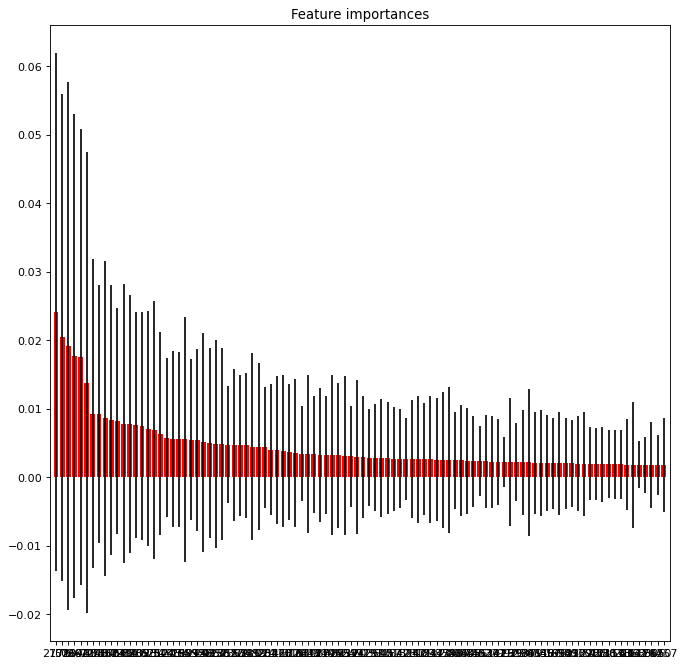

Most important words:
click language free linguistics university remove linguistic removed million get research money want offer company receive income conference de theory 

In [18]:
importances = spam_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in spam_RF.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
indices100 = indices[0:100]
fig=plt.figure(figsize=(10,10), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(indices100.shape[0]), importances[indices100], color="r", yerr=std[indices100], align="center")
plt.xticks(range(indices100.shape[0]), indices100)
plt.xlim([-1, indices100.shape[0]])
plt.show()
print("Most important words:")
for i in range(20):
    print(spam_data.feat2word[indices100[i]],end=" ")

## 4.2 <a id="sec4-1"></a> NIST

In [19]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])
#Xtrain = X[:1000,:]
#ytrain = y[:1000]
#Xtest = X[1000:,:]
#ytest = y[1000:]

#plt.gray();
#plt.matshow(digits.images[0]);
#plt.show();
#plt.matshow(digits.images[15]);
#plt.show();
#plt.matshow(digits.images[42]);
#plt.show();

from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

(1797, 64)
(1797, 8, 8)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


In [20]:
print(Xtrain.shape)
print(ytrain.shape)
digits_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
digits_rf.fit(Xtrain,ytrain)
prediction = digits_rf.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_rf.score(Xtest,ytest))
print("Confusion matrix:")
print(confusion_matrix(ytest, prediction))

(1000, 64)
(1000,)
Generalization error: 0.06524466750313676
Generalization score: 0.9347553324968633
Confusion matrix:
[[78  0  0  0  1  0  0  0  0  0]
 [ 0 75  0  1  0  1  0  0  0  3]
 [ 1  1 67  6  0  0  0  0  0  2]
 [ 0  1  0 66  0  4  0  3  5  0]
 [ 0  0  0  0 79  1  0  2  0  1]
 [ 0  0  0  0  0 80  2  0  0  0]
 [ 0  0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0  0 78  2  0]
 [ 0  2  0  0  1  5  0  1 66  1]
 [ 0  0  0  1  0  3  0  0  1 76]]


In [21]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = shuffle_and_split(X,y,1000)
    digits_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
    digits_rf.fit(Xtrain,ytrain)
    score += [digits_rf.score(Xtest,ytest)]
    print('*',end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

******************** done!
Average generalization score: 0.9698870765370138
Standard deviation: 0.005708563696902038


Let's identify the misclassified images.

In [22]:
# Retrain
Xtrain = X[:1000,:]
ytrain = y[:1000]
Xtest = X[1000:,:]
ytest = y[1000:]
digits_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
digits_rf.fit(Xtrain,ytrain);

<Figure size 640x480 with 0 Axes>

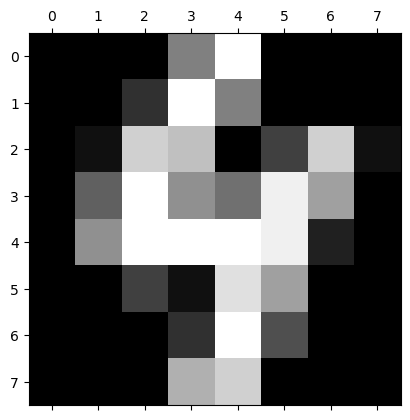

prediction on image number 1053 : [4]
correct label                : 4


In [23]:
# Examples
N = 1053
plt.gray();
plt.matshow(digits.images[N]) 
plt.show() 
x = digits.data[N,:]
print("prediction on image number", N, ":", digits_rf.predict([digits.data[N,:]]))
print("correct label                :", digits.target[N])

In [24]:
# Find misclassified examples
ypredict = digits_rf.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Itest = digits.images[1000:,:]
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
Imisclass = Itest[misclass,:]

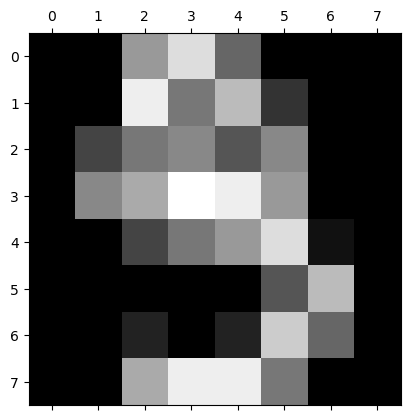

prediction on image number 1 : [5]
correct label                : 9


In [25]:
# Display misclassified examples
N = 1
plt.matshow(Imisclass[N]) 
plt.show() 
print("prediction on image number", N, ":", digits_rf.predict([Xmisclass[N,:]]))
print("correct label                :", ymisclass[N])

Let's take a look at the important pixels.

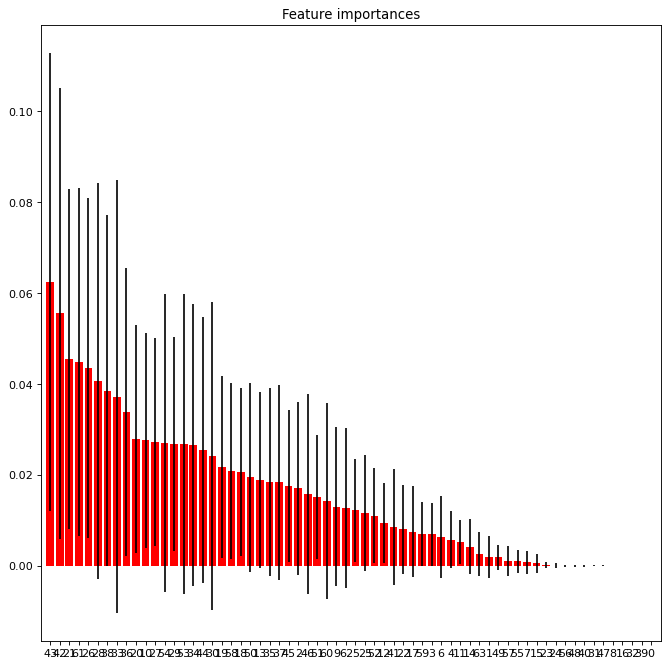

In [26]:
importances = digits_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in digits_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
fig=plt.figure(figsize=(10,10), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Let's plot a image of pixel importance.

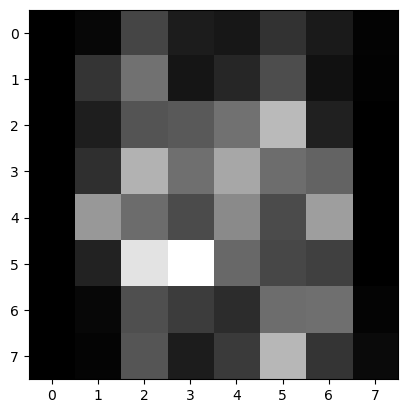

In [27]:
importances_image = importances.reshape((8,8))
plt.imshow(importances_image);